In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sci
from statsmodels.regression.linear_model import OLS

pd.set_option('float_format', '{:6.5f}'.format)
sns.set(style='ticks')

import warnings
warnings.filterwarnings("ignore")

In [5]:
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,4

In [6]:
df = pd.read_csv('bondreturns.txt',sep='\\t',index_col=[0,1])

In [7]:
df.head()

m1_12  m24_36  m48_60  m61_120
year month                                 
1952 1     0.00214 0.00501 0.00706  0.00377
     2     0.00142 0.00174 0.00216 -0.00202
     3     0.00218 0.00380 0.00605  0.00726
     4     0.00137 0.00249 0.00598  0.00566
     5     0.00103 0.00061 0.00089  0.00173

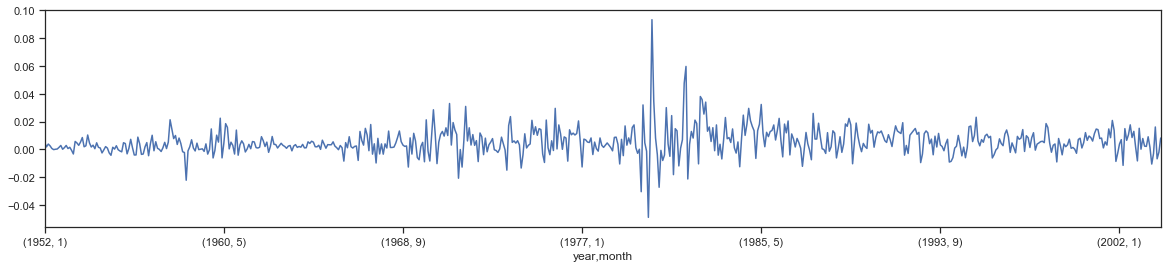

In [8]:
df['m24_36'].plot()
plt.show()

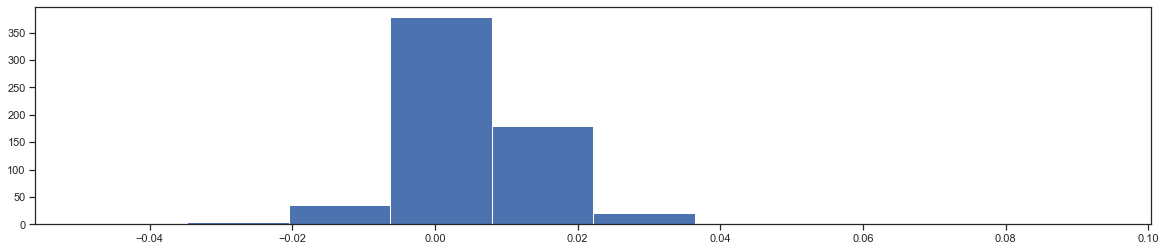

In [9]:
plt.hist(df['m24_36'])
plt.show()

We were talking in the lecture about that the returns have heavy tails, it has some asymmetry and the clasterization of the volatility.

In [10]:
#2
from scipy.stats import kurtosis,skew
print('kurtosis',kurtosis(df['m24_36']),'skewness',skew(df['m24_36']))

kurtosis 12.97795737443961 skewness 1.4015217514146772


We see that my hypothesis about the heavy tails and the asymmetry has been proved.

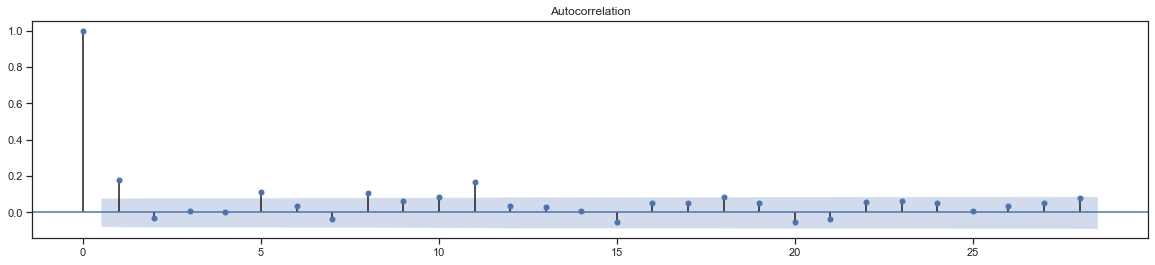

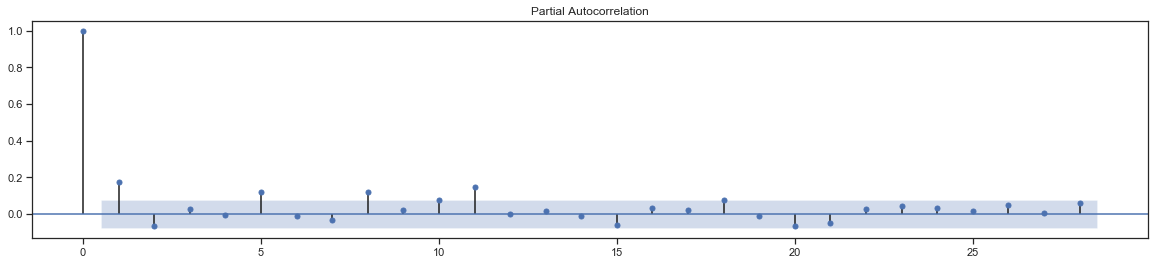

In [11]:
#3
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(df['m24_36'])
plot_pacf(df['m24_36'])
plt.show()

It is not a white noise process because there are some correlation between the lags.

In [12]:
from statsmodels.tsa.api import ARMA
# for i in range(0,10):
#     for j in range (0,10):
#         try:
#             model = ARMA(df['m24_36'],order=[i,j])
#             results = model.fit()
#             print(i,j,results.aic,results.bic)
#         except:
#             continue

In [13]:
model_arma = ARMA(df['m24_36'],order=[0,1])
results_arma = model_arma.fit()

In [14]:
results_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 m24_36   No. Observations:                  624
Model:                     ARMA(0, 1)   Log Likelihood                2002.900
Method:                       css-mle   S.D. of innovations              0.010
Date:                Sun, 01 Mar 2020   AIC                          -3999.801
Time:                        22:41:01   BIC                          -3986.492
Sample:                             0   HQIC                         -3994.629
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0053      0.000     11.333      0.000       0.004       0.006
ma.L1.m24_36     0.1962      0.041      4.775      0.000       0.116       0.277
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -5.0970           +0.0000j            5.0970            0.5000
-----------------------------------------------------------------------------
"""

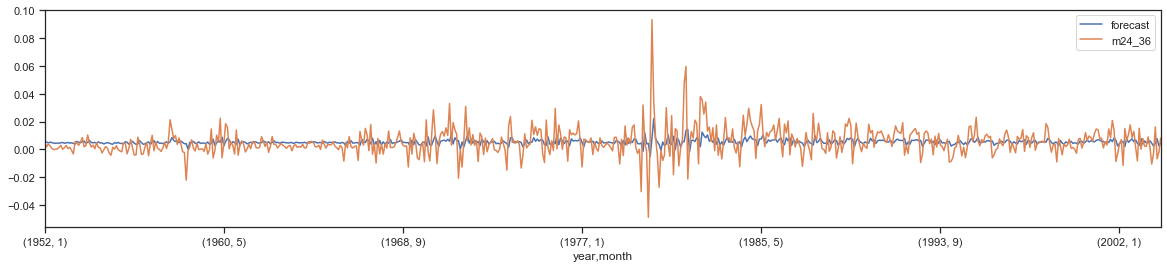

In [15]:
results_arma.plot_predict()
plt.show()

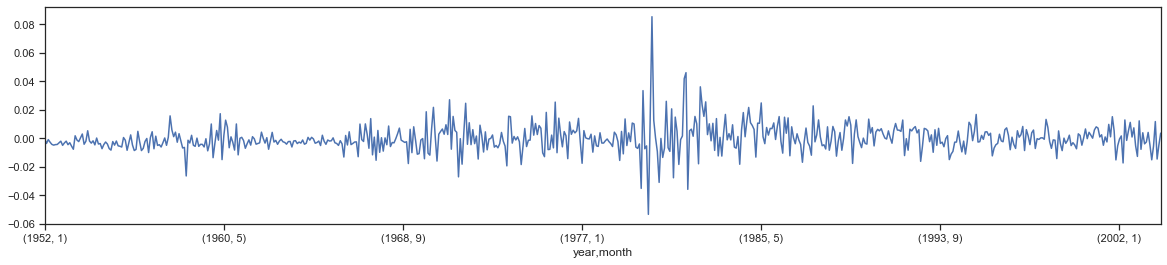

In [17]:
results_arma.resid.plot()

In [18]:
#4
from statsmodels.stats.diagnostic import het_arch
arch_mod = het_arch(results_arma.resid, maxlag=1)

In [19]:
arch_mod[3]

0.0027239995469854703

It is a pvalue for F test it means that H0 hypothesis is rejected, therefore there is some arch effect.

In [17]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [30]:
#5
from arch import arch_model
am=arch_model(y=df['m24_36'],p = 4,mean='Constant', vol='ARCH')
model_am = am.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: -2089.3438754928056
Iteration:      2,   Func. Count:     24,   Neg. LLF: -2095.3373107856605
Iteration:      3,   Func. Count:     38,   Neg. LLF: -2095.3565308167995
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2095.356531904645
            Iterations: 3
            Function evaluations: 47
            Gradient evaluations: 3


In [31]:
model_am.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 m24_36   R-squared:                      -0.013
Mean Model:             Constant Mean   Adj. R-squared:                 -0.013
Vol Model:                       ARCH   Log-Likelihood:                2095.36
Distribution:                  Normal   AIC:                          -4178.71
Method:            Maximum Likelihood   BIC:                          -4152.10
                                        No. Observations:                  624
Date:                Sun, Mar 01 2020   Df Residuals:                      618
Time:                        22:45:35   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.1657e-03  3.871e-04     10.760  5.289e-27 [3.407e-03,4.924e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.4578e-05  3.662e-06      9.443  3.618e-21 [2.740e-05,4.176e-05]
alpha[1]       0.1625  5.994e-02      2.711  6.709e-03   [4.502e-02,  0.280]
alpha[2]       0.1625  6.348e-02      2.560  1.048e-02   [3.808e-02,  0.287]
alpha[3]       0.1625      0.111      1.460      0.144  [-5.570e-02,  0.381]
alpha[4]       0.1625  9.363e-02      1.735  8.266e-02  [-2.102e-02,  0.346]
============================================================================

Covariance estimator: robust
"""

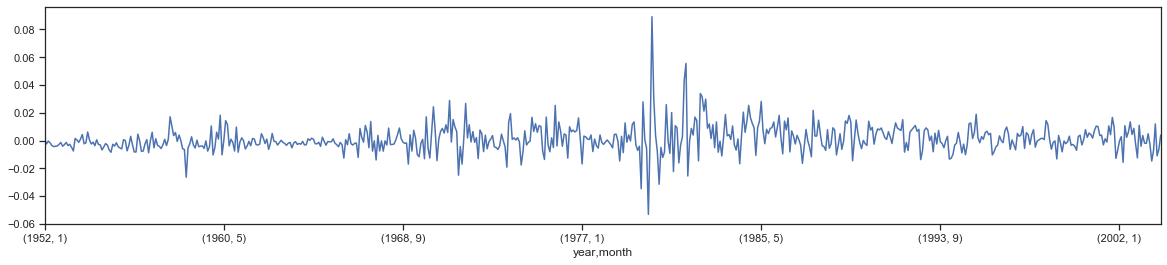

In [32]:
model_am.resid.plot()

In [33]:
model_am.forecast(horizon=10).variance.values[-1::]

array([[8.62055227e-05, 7.71468833e-05, 7.00362630e-05, 7.50579298e-05,
        8.47010081e-05, 8.44565305e-05, 8.56443579e-05, 8.81806702e-05,
        9.03131144e-05, 9.12250835e-05]])

In [34]:
#6

gam = arch_model(y=df['m24_36'],p = 1,q=1,mean='Constant', vol='GARCH')
model_garch = gam.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -2109.5523535538955
Iteration:      2,   Func. Count:     20,   Neg. LLF: -2120.547959709212
Iteration:      3,   Func. Count:     36,   Neg. LLF: -2119.973674578765
Iteration:      4,   Func. Count:     52,   Neg. LLF: -2120.6477477423687
Iteration:      5,   Func. Count:     65,   Neg. LLF: -2120.648362740174
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2120.6483646783045
            Iterations: 9
            Function evaluations: 65
            Gradient evaluations: 5


//anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:711: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [35]:
model_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 m24_36   R-squared:                      -0.022
Mean Model:             Constant Mean   Adj. R-squared:                 -0.022
Vol Model:                      GARCH   Log-Likelihood:                2120.65
Distribution:                  Normal   AIC:                          -4233.30
Method:            Maximum Likelihood   BIC:                          -4215.55
                                        No. Observations:                  624
Date:                Sun, Mar 01 2020   Df Residuals:                      620
Time:                        22:45:36   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.8341e-03  3.077e-06   1245.872      0.000 [3.828e-03,3.840e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.9758e-06  1.046e-11  1.889e+05      0.000 [1.976e-06,1.976e-06]
alpha[1]       0.1000  2.832e-02      3.531  4.144e-04   [4.449e-02,  0.156]
beta[1]        0.8800  2.116e-02     41.586      0.000     [  0.839,  0.921]
============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

In [36]:
model_garch.forecast(horizon=10).variance.values[-1::]

array([[7.19694489e-05, 7.25059068e-05, 7.30316355e-05, 7.35468497e-05,
        7.40517596e-05, 7.45465713e-05, 7.50314868e-05, 7.55067040e-05,
        7.59724168e-05, 7.64288154e-05]])

In [37]:
print('garch model',model_garch.aic,model_garch.bic)
print('arch model',model_am.aic,model_am.bic)

garch model -4233.296729356609 -4215.552127883131
arch model -4178.71306380929 -4152.096161599074


In [38]:
results_arma.forecast(steps=10)[0]

array([0.00602964, 0.00529891, 0.00529891, 0.00529891, 0.00529891,
       0.00529891, 0.00529891, 0.00529891, 0.00529891, 0.00529891])

There is some difference in the predictions of both models. Garch have more stable predictions, meaning there is no much difference in the steps but arch predicts that the volatility differs.

In [39]:
std_arch_cond = model_am.resid/model_am.conditional_volatility
std_arch = model_am.resid / model_am.resid.std()
std_garch_cond = model_garch.resid/model_garch.conditional_volatility
std_garch = model_garch.resid / model_garch.resid.std()

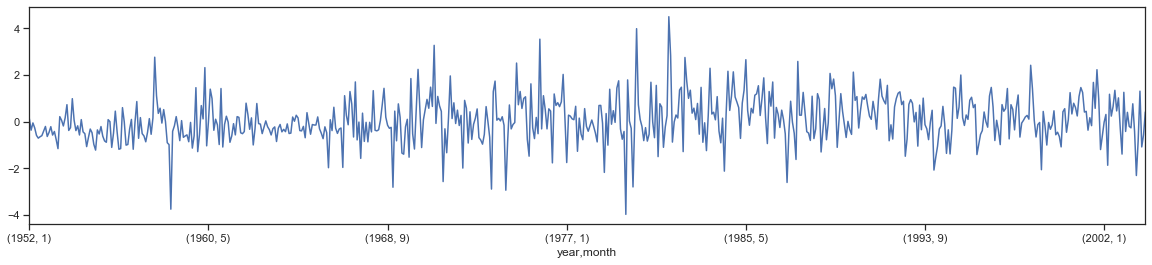

In [47]:
std_arch_cond.plot()

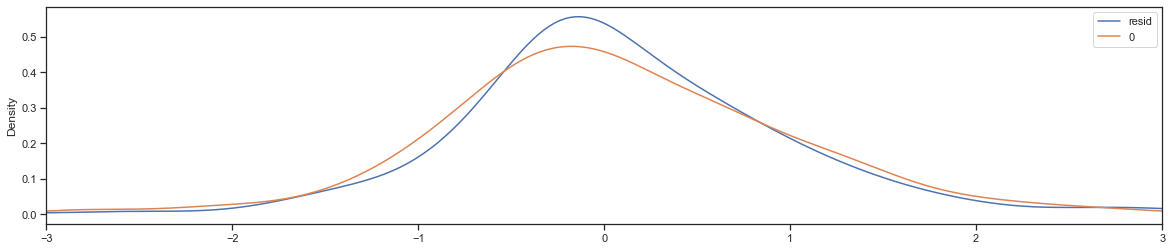

In [40]:
pd.concat([std_arch,std_arch_cond],1).plot(kind='kde',xlim = (-3,3))
plt.show()

In [41]:
sci.describe(std_arch_cond)

DescribeResult(nobs=624, minmax=(-3.97496189106448, 4.494567476939708), mean=0.06719608334295503, variance=0.9672511702585485, skewness=0.20950017175736074, kurtosis=2.0169666008572014)

In [42]:
sci.describe(std_arch)

DescribeResult(nobs=624, minmax=(-5.34266682882974, 8.960557073769774), mean=0.11379275171565897, variance=0.9999999999999994, skewness=1.401521751414677, kurtosis=12.977957374439608)

In [44]:
sci.describe(std_garch)

DescribeResult(nobs=624, minmax=(-5.30933695342981, 8.993886949169704), mean=0.14712262711558918, variance=0.9999999999999994, skewness=1.4015217514146772, kurtosis=12.977957374439608)

In [45]:
sci.describe(std_garch_cond)

DescribeResult(nobs=624, minmax=(-4.364952827482115, 4.491920771347123), mean=0.08905338750899872, variance=0.9612461159426219, skewness=0.009737555477905955, kurtosis=1.9369369644247971)

Yes, it has been mitigated, in both cases kurtosis is less and skewness is practically equal to zero 